<a href="https://colab.research.google.com/github/okayteakay/Interpretable-ML/blob/main/DFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import PIL
import skimage, skimage.transform
import cv2 
import math
import time
import os
%matplotlib inline
import torchvision
from torchvision import models

In [ ]:
def imresize(img, height=None, width=None):
  # load image
  if height is not None and width is not None:
      ny = height
      nx = width
  elif height is not None:
      ny = height
      nx = img.shape[1] * ny / img.shape[0]
  elif width is not None:
      nx = width
      ny = img.shape[0] * nx / img.shape[1]
  else:
      ny = img.shape[0]
      nx = img.shape[1]

  return skimage.transform.resize(img, (int(ny), int(nx)), mode='constant')

In [ ]:
def show_heatmaps(imgs, masks, K, enhance=1, title=None, cmap='gist_rainbow'):

    if K > 0:
        _cmap = plt.cm.get_cmap(cmap)
        colors = [np.array(_cmap(i)[:3]) for i in np.arange(0,1,1/K)]
    plt.figure(figsize=(4 * len(imgs), 4))
    if title is not None:
        plt.suptitle(title+'\n', fontsize=24).set_y(1.05)
    for i in range(len(imgs)):
        plt.subplot(1, len(imgs), i + 1)

        img = imgs[i]
        if img.max()<=1:
            img *= 255
        img = np.array(PIL.ImageEnhance.Color(PIL.Image.fromarray(np.uint8(img))).enhance(enhance))
        plt.imshow(img)
        plt.axis('off')
        for k in range(K):
            layer = np.ones((*img.shape[:2],4))
            for c in range(3): layer[:,:,c] *= colors[k][c]
            mask = masks[i][k]
            layer[:,:,3] = mask
            plt.imshow(layer)
            plt.axis('off')

    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.show()


In [ ]:
def nmf(V, k, H = None, W = None, random_seed = None, max_iter = 200, tol = 1e-4, cuda = True, verbose = False):

  if verbose is True:
    time_ = time.time()
  
  scale = math.sqrt(V.mean()/k)

  if random_seed is not None:
    if cuda:
      current_random_seed = torch.cuda.initial_seed()
      torch.cuda.manual_seed(random_seed)
    else:
      current_random_seed = torch.initial_seed()
      torch.manual_seed(random_seed)

  if W is None:
    if cuda:
      W = torch.cuda.FloatTensor(V.size(0), k).normal_()
    else:
      W = torch.randn(V.size(0), k)
    W *= scale
  
  update_H = True
  if H is None:
    if cuda:
      H = torch.cuda.FloatTensor(k, V.size(1)).normal_()
    else:
      H = torch.randn(k, V.size(1))
    H *= scale
  else:
    update_H = False

  
  if random_seed is not None:
    if cuda:
      torch.cuda.manual_seed(current_random_seed)
    else:
      torch.manual_seed(current_random_seed)
  
  W = torch.abs(W)
  H = torch.abs(H)

  init_error = loss_function(V, W, H)
  previous_error = init_error


  VH = None
  HH = None
  for iter in range(max_iter):
    W, H, VH, HH = multiplicative_update(V, W, H, update_H = update_H, VH = VH, HH = HH)
    if tol > 0 and iter % 10 == 0:
      error = loss_function(V, W, H)

      if (previous_error - error)/init_error < tol:
        break
      previous_error = error
  
  if verbose:
        print('Exited after {} iterations. Total time: {} seconds'.format(n_iter+1, time.time()-start_time))
  return W, H

In [ ]:
def multiplicative_update(V, W, H, update_H=True, VH=None, HH=None):
    # update operation for W
    if VH is None:
        assert HH is None
        Ht = torch.t(H)
        VH = torch.mm(V, Ht)
        HH = torch.mm(H, Ht)

    WHH = torch.mm(W, HH)
    WHH[WHH == 0] = EPSILON
    W *= VH / WHH

    if update_H:
        # update operation for H (after updating W)
        Wt = torch.t(W)
        WV = torch.mm(Wt, V)
        WWH = torch.mm(torch.mm(Wt, W), H)
        WWH[WWH == 0] = EPSILON
        H *= WV / WWH
        VH, HH = None, None

    return W, H, VH, HH


In [ ]:
# NMF objective
def loss_function(V, W, H, square_root=True):
    # Frobenius norm
    return torch.norm(V - torch.mm(W, H))

In [ ]:
cuda = True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


(6, 3, 224, 224)
(6, 3, 224, 224)
(6, 3, 224, 224)


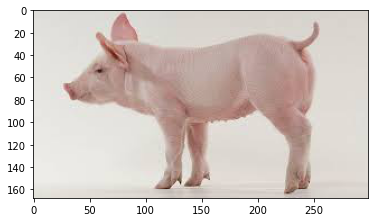

In [ ]:
data_path = '/content/gdrive/MyDrive/Project/Pigs' 
filenames = os.listdir(data_path)

filename_ = []
for filename in filenames:
  # print(filename[-3:])
  if filename[-3:] == 'jpg':
    filename_.append(filename)

# Load images
raw_images = [plt.imread(os.path.join(data_path, filename)) for filename in filename_]
plt.imshow(raw_images[2])
raw_images = [imresize(img, 224, 224) for img in raw_images] # resize
raw_images = np.stack(raw_images)

# Preprocess
images = raw_images.transpose((0,3,1,2)).astype('float32') # to numpy, NxCxHxW, float32
print(images.shape)
images -= np.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)) # zero mean
print(images.shape)
images /= np.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)) # unit variance
print(images.shape)

images = torch.from_numpy(images) # convert to Pytorch tensor
if cuda:
    images = images.cuda()

In [ ]:
pig = plt.imread('/content/gdrive/MyDrive/Project/Pigs/pig1.jpg')
pig = imresize(pig, 224, 224)
print(pig.shape)
pig = pig.transpose((2,0,1)).astype('float32')
print(pig.shape)

(224, 224, 3)
(3, 224, 224)


In [ ]:
pig = torch.from_numpy(pig) # convert to Pytorch tensor
if cuda:
    pig = pig.cuda()

In [ ]:
net = models.vgg19(pretrained=True) # load pre-trained VGG-19
if cuda:
    net = net.cuda()
del net.features._modules['36'] # remove max-pooling after final conv layer

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
with torch.no_grad():
    features = net.features(images)
    flat_features = features.permute(0, 2, 3, 1).contiguous().view((-1, features.size(1))) # NxCxHxW -> (N*H*W)xC

print('Reshaped features from {0}x{1}x{2}x{3} to ({0}*{2}*{3})x{1} = {4}x{1}'.format(*features.shape, flat_features.size(0)))


Reshaped features from 6x512x14x14 to (6*14*14)x512 = 1176x512


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
EPSILON = 1e-7

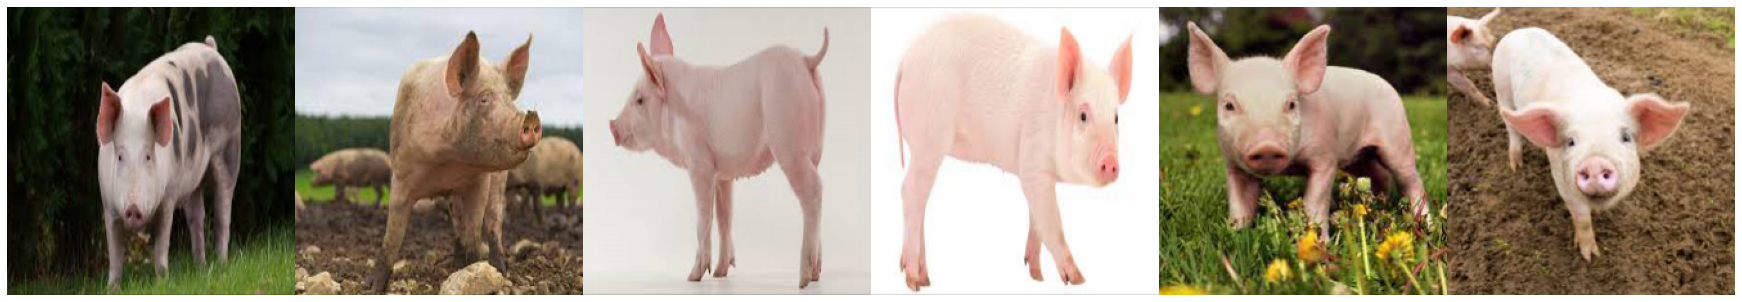

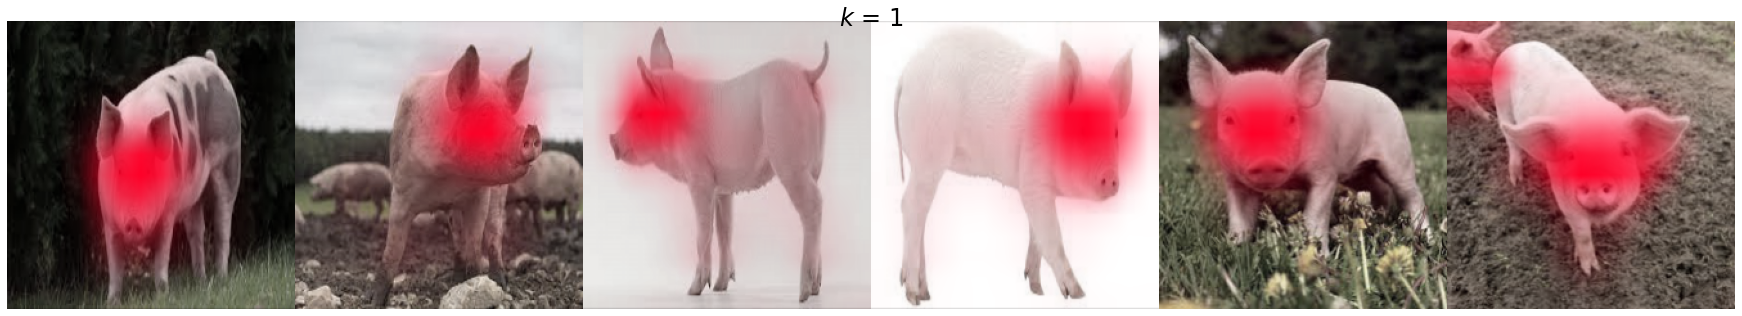

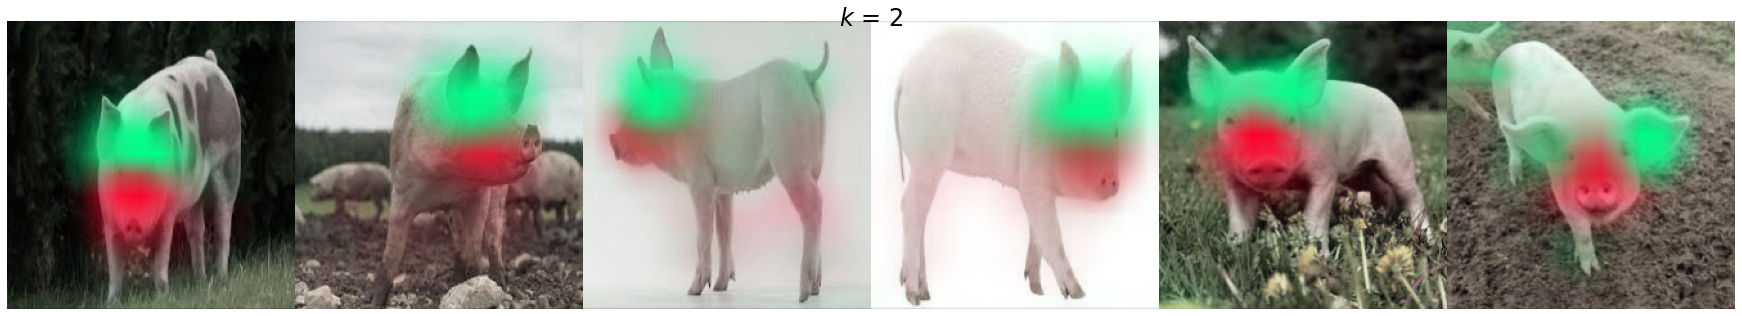

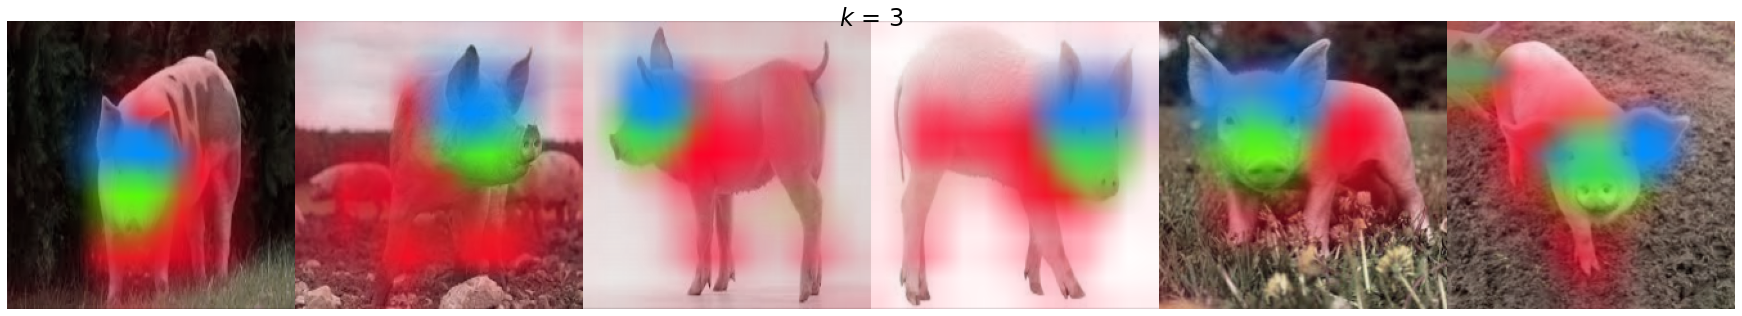

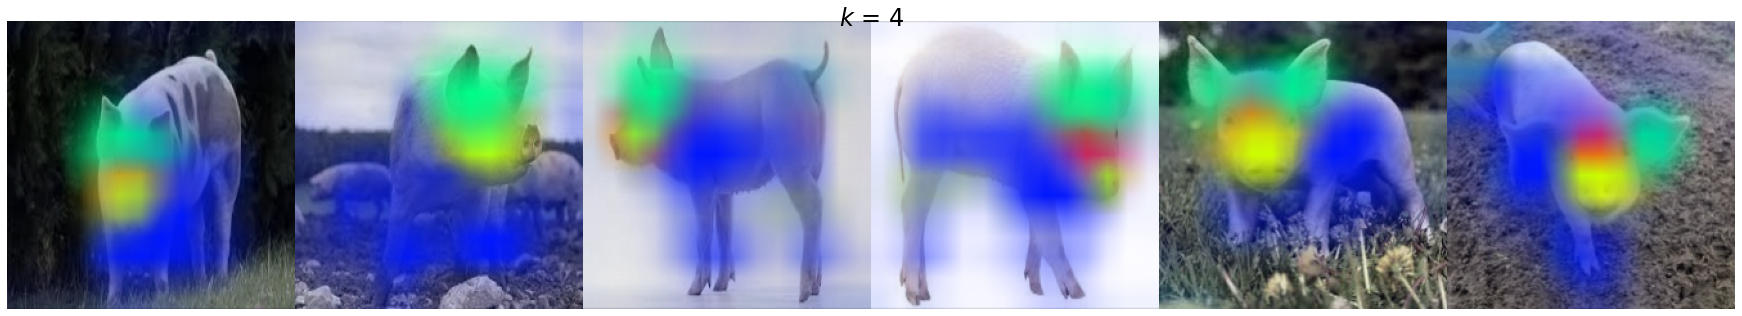

In [ ]:
# Show original images
show_heatmaps(raw_images, None, 0, enhance=1)

# Run NMF with K=(1,2,3,4) Note: the permutation of factors is random and is not consistent across iterations
for K in range(1,5):
    with torch.no_grad():
        W, _ = nmf(flat_features, K, random_seed=0, cuda=cuda, max_iter=50)

    heatmaps = W.cpu().view(features.size(0), features.size(2), features.size(3), K).permute(0,3,1,2) # (N*H*W)xK -> NxKxHxW
    heatmaps = torch.nn.functional.interpolate(heatmaps, size=(224, 224), mode='bilinear', align_corners=False) ## 14x14 -> 224x224
    heatmaps /= heatmaps.max(dim=3, keepdim=True)[0].max(dim=2, keepdim=True)[0] # normalize by factor (i.e., 1 of K)
    heatmaps = heatmaps.cpu().numpy()
    
    # Show heat maps
    show_heatmaps(raw_images, heatmaps, K,  title='$k$ = {}'.format(K), enhance=0.3)